In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import timedelta
import glob
import gc


pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 999
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
df = pd.read_csv('../data/archive.zip')
# fix futher pmml issue wnen it can't map fields from model with data when fields has spaces
df.columns = df.columns.str.replace(' ', '_')
df = df.drop(columns=['Id'])
df

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  alcohol  quality
0               7.4             0.700         0.00             1.9      0.076                 11.0                  34.0  0.99780  3.51       0.56      9.4        5
1               7.8             0.880         0.00             2.6      0.098                 25.0                  67.0  0.99680  3.20       0.68      9.8        5
2               7.8             0.760         0.04             2.3      0.092                 15.0                  54.0  0.99700  3.26       0.65      9.8        5
3              11.2             0.280         0.56             1.9      0.075                 17.0                  60.0  0.99800  3.16       0.58      9.8        6
4               7.4             0.700         0.00             1.9      0.076                 11.0                  34.0  0.99780  3.51       0.56      9.4        5
...             ...               ...          ...             ...        ...                  ...                   ...      ...   ...        ...      ...      ...
1138            6.3             0.510         0.13             2.3      0.076                 29.0                  40.0  0.99574  3.42       0.75     11.0        6
1139            6.8             0.620         0.08             1.9      0.068                 28.0                  38.0  0.99651  3.42       0.82      9.5        6
1140            6.2             0.600         0.08             2.0      0.090                 32.0                  44.0  0.99490  3.45       0.58     10.5        5
1141            5.9             0.550         0.10             2.2      0.062                 39.0                  51.0  0.99512  3.52       0.76     11.2        6
1142            5.9             0.645         0.12             2.0      0.075                 32.0                  44.0  0.99547  3.57       0.71     10.2        5

[1143 rows x 12 columns]

In [3]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [4]:
df['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

In [5]:
y = df['quality']
X = df.drop('quality', axis=1)

In [6]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
y.value_counts()

5    483
6    483
7    483
4    483
8    483
3    483
Name: quality, dtype: int64

In [7]:
from sklearn import preprocessing

# fix futher pmml issue when it can't map correct predictions when target feature is spare
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y)

In [8]:
np.unique(y_label)

array([0, 1, 2, 3, 4, 5])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit


train_inds, test_inds = next(StratifiedShuffleSplit(test_size=.20, n_splits=2).split(X, y_label))

y_train = y_label[train_inds]
X_train = X.iloc[train_inds]
y_test = y_label[test_inds]
X_test = X.iloc[test_inds]

In [10]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb


callbacks = [lgb.early_stopping(100, verbose=0), lgb.log_evaluation(period=1)]

fit_params={'lgbm__eval_metric': 'multi_logloss',
            'lgbm__eval_set' : [(X_test, y_test)],
            'lgbm__eval_names': ['valid'],
            'lgbm__feature_name': 'auto',
            'lgbm__callbacks': callbacks
           }

lgbm = lgb.LGBMClassifier(num_leaves=9,
                      max_depth=-1,
                      random_state=314,
                      n_jobs=7,
                      n_estimators=1000,
                      objective='multiclass',
                      learning_rate=0.1)

pipeline = Pipeline([
    ('lgbm', lgbm)
])

pipeline.fit(X_train, y_train, **fit_params)

print(lgbm.score(X_train, y_train))
print(lgbm.score(X_test, y_test))

[1]	valid's multi_logloss: 1.6242
[2]	valid's multi_logloss: 1.50126
[3]	valid's multi_logloss: 1.39644
[4]	valid's multi_logloss: 1.29745
[5]	valid's multi_logloss: 1.21993
[6]	valid's multi_logloss: 1.1537
[7]	valid's multi_logloss: 1.09676
[8]	valid's multi_logloss: 1.05217
[9]	valid's multi_logloss: 1.00908
[10]	valid's multi_logloss: 0.967326
[11]	valid's multi_logloss: 0.931234
[12]	valid's multi_logloss: 0.898225
[13]	valid's multi_logloss: 0.865823
[14]	valid's multi_logloss: 0.841447
[15]	valid's multi_logloss: 0.817831
[16]	valid's multi_logloss: 0.797675
[17]	valid's multi_logloss: 0.777327
[18]	valid's multi_logloss: 0.759596
[19]	valid's multi_logloss: 0.743396
[20]	valid's multi_logloss: 0.729207
[21]	valid's multi_logloss: 0.713178
[22]	valid's multi_logloss: 0.701179
[23]	valid's multi_logloss: 0.688664
[24]	valid's multi_logloss: 0.67863
[25]	valid's multi_logloss: 0.665952
[26]	valid's multi_logloss: 0.655833
[27]	valid's multi_logloss: 0.6461
[28]	valid's multi_loglo

In [11]:
from sklearn.metrics import confusion_matrix

y_pred = lgbm.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[97  0  0  0  0  0]
 [ 0 93  2  1  0  0]
 [ 0  4 67 24  2  0]
 [ 1  1 23 57 15  0]
 [ 0  0  0  7 87  2]
 [ 0  0  0  1  3 93]]


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

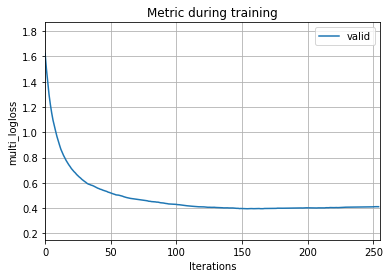

In [12]:
lgb.plot_metric(lgbm)


In [13]:
from sklearn import metrics

print(metrics.classification_report(y_test, lgbm.predict(X_test), ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        97
           1       0.95      0.97      0.96        96
           2       0.73      0.69      0.71        97
           3       0.63      0.59      0.61        97
           4       0.81      0.91      0.86        96
           5       0.98      0.96      0.97        97

    accuracy                           0.85       580
   macro avg       0.85      0.85      0.85       580
weighted avg       0.85      0.85      0.85       580



In [14]:
%%timeit -n 100000 -r 1

res = pipeline.predict(X_test.sample())

753 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)


In [15]:
X_test.to_csv('../wine_test.csv', index=None)

# Finally we are going to convert this model to java compatible and verify its performance there

# Solution #1:
- export only lgbm using the model booster
- convert it to pmml via https://github.com/jpmml/jpmml-lightgbm

In [16]:
lgbm.booster_.save_model("../wine_classifier_1.txt")

# Solution #2

- use https://github.com/SoftwareAG/nyoka to directly convert sklearn pipeline to PMML
- unfortunetelly exported model is not fully compatible with JPMML-Evaluator so we will not use it in Java

In [17]:
from nyoka import lgb_to_pmml

lgb_to_pmml(pipeline, X.columns, "quality", "../wine_classifier_2.pmml")

# Solution #3
- construct pipeline using PMML wrapper over standard sklearn features
- use sklearn2pmml to export to PMML dirtectly

In [18]:
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

pipeline = PMMLPipeline([
  ('lgbm', lgbm)
])
pipeline.fit(X_train, y_train, **fit_params)
print(lgbm.score(X_train, y_train))
print(lgbm.score(X_test, y_test))

sklearn2pmml(pipeline, "../wine_classifier_3.pmml", with_repr = True)

[1]	valid's multi_logloss: 1.6242
[2]	valid's multi_logloss: 1.50126
[3]	valid's multi_logloss: 1.39644
[4]	valid's multi_logloss: 1.29745
[5]	valid's multi_logloss: 1.21993
[6]	valid's multi_logloss: 1.1537
[7]	valid's multi_logloss: 1.09676
[8]	valid's multi_logloss: 1.05217
[9]	valid's multi_logloss: 1.00908
[10]	valid's multi_logloss: 0.967326
[11]	valid's multi_logloss: 0.931234
[12]	valid's multi_logloss: 0.898225
[13]	valid's multi_logloss: 0.865823
[14]	valid's multi_logloss: 0.841447
[15]	valid's multi_logloss: 0.817831
[16]	valid's multi_logloss: 0.797675
[17]	valid's multi_logloss: 0.777327
[18]	valid's multi_logloss: 0.759596
[19]	valid's multi_logloss: 0.743396
[20]	valid's multi_logloss: 0.729207
[21]	valid's multi_logloss: 0.713178
[22]	valid's multi_logloss: 0.701179
[23]	valid's multi_logloss: 0.688664
[24]	valid's multi_logloss: 0.67863
[25]	valid's multi_logloss: 0.665952
[26]	valid's multi_logloss: 0.655833
[27]	valid's multi_logloss: 0.6461
[28]	valid's multi_loglo

/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/subprocess.py:946: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


# Verrify that the exported model predicts correctly

In [19]:
test = pd.read_csv('../wine_predictions_3.csv', index_col=False)
f_test = test.drop('prediction', axis=1)
test['lgbm_prediction'] = pipeline.predict(f_test)
test

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates    alcohol  prediction  lgbm_prediction
0         7.200000          0.655000     0.030000        1.800000   0.078000             7.000000             12.000000  0.995870  3.340000   0.390000   9.500000           2                2
1        10.700000          0.350000     0.530000        2.600000   0.070000             5.000000             16.000000  0.997200  3.150000   0.650000  11.000000           5                5
2         7.959722          0.553979     0.221708        4.246943   0.054322             4.080557              9.459722  0.996017  3.334028   0.554597  11.405694           1                1
3        11.599048          0.580089     0.659865        2.199978   0.073997            10.002214             47.000443  1.000799  3.250013   0.569996   9.000155           0                0
4         7.000000          0.690000     0.000000        1.900000   0.114000             3.000000             10.000000  0.996360  3.350000   0.600000   9.700000           2                2
5         8.200000          0.730000     0.210000        1.700000   0.074000             5.000000             13.000000  0.996800  3.200000   0.520000   9.500000           2                2
6         6.957272          0.806636     0.003606        2.136061   0.063606             5.639394             13.360606  0.996662  3.492637   0.599182  10.360606           1                1
7         8.682621          0.486894     0.393106        2.527951   0.074323             7.161477             16.720492  0.993706  3.186025   0.700434  12.513034           5                5
8        10.100000          0.430000     0.400000        2.600000   0.092000            13.000000             52.000000  0.998340  3.220000   0.640000  10.000000           3                3
9         7.800000          0.870000     0.260000        3.800000   0.107000            31.000000             67.000000  0.996680  3.260000   0.460000   9.200000           2                2
10        9.827835          0.451150     0.400888        5.647581   0.086048             9.286281             45.810468  0.999838  3.306249   0.760484  10.381047           4                4
11        8.622347          0.633095     0.285788        2.551286   0.086579            14.868162             44.934081  0.997600  3.277765   0.517106   9.264469           1                1
12        6.298289          0.729537     0.033699        2.100000   0.065897             5.719173             12.157519  0.996356  3.568938   0.605788  10.196579           1                1
13        8.000000          0.580000     0.160000        2.000000   0.120000             3.000000              7.000000  0.994540  3.220000   0.580000  11.200000           3                3
14       12.400000          0.350000     0.490000        2.600000   0.079000            27.000000             69.000000  0.999400  3.120000   0.750000  10.400000           3                3
15       11.100000          0.350000     0.480000        3.100000   0.090000             5.000000             21.000000  0.998600  3.170000   0.530000  10.500000           2                2
16        6.200000          0.430000     0.220000        1.800000   0.078000            21.000000             56.000000  0.996330  3.520000   0.600000   9.500000           2                2
17        8.100000          0.290000     0.360000        2.200000   0.048000            35.000000             53.000000  0.995000  3.270000   1.010000  12.400000           4                4
18        9.900000          0.590000     0.070000        3.400000   0.102000            32.000000             71.000000  1.000150  3.310000   0.710000   9.800000           2                2
19        7.500000          0.490000     0.200000        2.600000   0.332000             8.000000             14.000000  0.996800  3.210000   0.900000  10.500000           3            

In [20]:
test.loc[test['prediction'] != test['lgbm_prediction']]

Empty DataFrame
Columns: [fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, prediction, lgbm_prediction]
Index: []